In [1]:
import os

import numpy   as np
import pandas  as pd
import seaborn as sns

from matplotlib.pyplot import subplots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from sklearn.svm             import SVC
from sklearn.metrics         import classification_report

from aequitas.preprocessing import preprocess_input_df
from aequitas.group         import Group
from aequitas.bias          import Bias
from aequitas.fairness      import Fairness
from aequitas.plotting      import Plot


%matplotlib inline

In [2]:
# global variables

DATASET_PATH = os.path.join(os.getcwd(), "hearth_disease.csv")

# 1. What is the dataset ?

The dataset pertains to the diagnosis of heart disease and consists of numeric-valued attributes. It contains 693 (one duplicate row) instances, with only 12 attributes being used for analysis, which are described as below:

   
   01. `age`: displays the age of the individual in years.
   
   
   02. `sex`: displays the gender of the individual using the following format:
      * 0 = Female
      * 1 = Male
   
   03. `cp`: displays the type of chest-pain experienced by the individual using the following format:
      * 1 = Typical angina
      * 2 = Atypical angina
      * 3 = Non-anginal pain
      * 4 = Asymptotic
   
   
   04. `trestbps`: displays the resting blood pressure value of an individual in mmHg (unit).
   
   
   05. `chol`: displays the serum cholesterol in mg/dl (unit).
   
   
   06. `fbs`: compares the fasting blood sugar value of an individual with 120 mg/dl. If fasting blood sugar > 120 mg/dl then it is 1 (true), otherwise it is 0 (false).
   
   
   07. `restecg`: displays resting electrocardiographic results using the following format:
      * 0 = Normal
      * 1 = Having ST-T wave abnormality
      * 2 = Left ventricular hyperthrophy
   
   08. `thalach`: displays the max heart rate achieved by an individual.
   
   
   09. `exang`: exercise induced angina using the following format:
      * 1 = Yes
      * 0 = No
   
   10. `oldpeak`: displays ST depression induced by exercise relative to rest.
   
   
   11. `race`: the race of the invidual using the following format:
      * 0 = Hungarian-American
      * 1 = Swiss
   
   12. `num`: displays whether the individual is suffering from heart disease or not using the following format:
      * 0 = absence
      * 1 = present

In [3]:
# reading the preprocessed dataset
dataframe = pd.read_csv(DATASET_PATH, index_col = [0])

# drop duplicate rows from dataframe
dataframe = dataframe.drop_duplicates()

dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,num,race
0,32,1,1,95,0,0,0,127,0,0.7,1,1
3,36,1,4,110,0,0,0,125,1,1.0,1,1
4,38,0,4,105,0,0,0,166,0,2.8,1,1
5,38,0,4,110,0,0,0,156,0,0.0,1,1
6,38,1,3,100,0,0,0,179,0,-1.1,0,1


# 2. Preprocess the dataset and apply data formatting for Aequitas

Aequitas has several requirements for the input dataframe:

   * The dataframe must contain a `score` column, which represents a binary decision (either 0 or 1).
   
   * The dataframe must also contain a `label_value` column, which represents the ground truth value of a binary decision.
   
   * Additionally, the dataframe must have at least one attribute column (such as sex or race), which the model used to generate the score column.
   
It's important to note that Aequitas assumes the `score` and `label_value` columns are both binary-valued. The other columns in the dataframe represent attributes that were used by the model to generate the `score` column.

In our dataset, we have identified `sex` and `race` as the protected or sensitive attributes on which we should search for discrimination. Additionally, we have a `label_value` column that represents the ground truth value of a binary decision.

To generate the `score` column, we will create a classifier using a Support Vector Classifier with RBF kernel. This classifier will use the sex and race attributes, as well as any other relevant attributes, to make binary decisions and generate scores.

In [4]:
def split_dataset(X: pd.DataFrame, y: pd.DataFrame, test_size: float = 0.2) -> tuple:
    """
    Split dataset into training and testing set in a way that guarantees that the distribution of
    data in sex, race, and num columns be same.
    This is necessary to done because it may be happen that there would be no individual whose race 
    be Swiss (as the number of instances with this attribute is low).
    
    Args:
        - X (pd.DataFrame):  A dataframe representing the input features.
        - y (pd.DataFrame):  A dataframe representing the target feature.
        - test_size (float): A number representing how much of data should be considered as testing set.
        
    Returns:
        tuple: training and testing instances.
    """
    # create a copy and add a column that append the values of `sex`, `race`, and `num` features.
    X_prime = X.copy()
    X_prime["sex_race_num"] = X_prime["sex"].astype(str)  + "_" + \
                              X_prime["race"].astype(str) + "_" + \
                              y.astype(str)
    
    # split the dataset w.r.t. the new feature added.
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(
        X_prime, y, test_size = test_size, stratify = X_prime["sex_race_num"], random_state = 1234
    )
    
    # the added feature is redundant, therefore we delete it from the dataset
    Xtrain = Xtrain.drop("sex_race_num", axis = 1)
    Xtest  = Xtest.drop("sex_race_num",  axis = 1)
    
    return Xtrain, Xtest, Ytrain, Ytest

In [5]:
def preprocess_dataset(X_train: pd.DataFrame, X_test: pd.DataFrame) -> tuple:
    """
    Preprocesses the dataset using StandardScaler function from sklearn.
    
    Args:
        - training_features (pd.DataFrame): The training data features.
        
        - testing_features (pd.DataFrame): The testing data features.
    
    Returns:
        tuple: A tuple containing preprocessed training and testing data features.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled

In [6]:
def train_classifier(classifier, train_set: tuple, test_set: tuple) -> np.ndarray:
    """
    Trains the given classifier on the given training set and evaluates it on the testing set.

    Args:
        - classifier (object): An instance of a classification model from scikit-learn.
        
        - train_set  (tuple):  A tuple containing the training data as its first element and
                               the corresponding labels as its second element.
        
        - test_set   (tuple):  A tuple containing the testing data as its first element and
                               the corresponding labels as its second element.

    Returns:
        predictions (array): A numpy array containing the predicted labels for the test data.
    """
    classifier.fit(train_set[0], train_set[1])
    predictions = classifier.predict(test_set[0])
    print(classification_report(test_set[1], predictions, target_names = ["Absence", "Present"]))
    return predictions

In [7]:
def create_aequitas_df(y_pred: np.ndarray, y_true: pd.DataFrame, X_test: pd.DataFrame) -> pd.DataFrame:
    """
    Create a dataframe that is compatible with the Aequitas tool from model predictions.
    
    Args:
        - y_pred: numpy array of predicted binary labels.
        
        - y_true: pandas dataframe with true binary labels.
        
        - X_test: pandas dataframe representing the testing input features.
        
    Returns:
        pandas dataframe with the required columns for Aequitas.
    """
    assert y_pred.shape == y_true.shape, "predictions and y_true must have the same shape"
    
    df_aequitas = pd.DataFrame()
    df_aequitas["score"] = y_pred
    df_aequitas["label_value"] = y_true.values.astype(int)
    
    try:
        df_aequitas["sex"]  = X_test["sex"].map({0: "Female", 1: "Male"}).astype(str).values
        df_aequitas["race"] = X_test["race"].map({0: "Hungarian-American", 1: "Swiss"}).astype(str).values
    except Exception:
        return df_aequitas
    
    return df_aequitas

In [8]:
def data_formatting_for_aequitas(model: object, train_set: tuple, test_set: tuple) -> pd.DataFrame:
    """
    Put all in one function.
    
    Args:
        - model     (object):  A classifier.
        - train_set  (tuple):  A tuple containing the training data as its first element and
                               the corresponding labels as its second element.
        
        - test_set   (tuple):  A tuple containing the testing data as its first element and
                               the corresponding labels as its second element.
                               
    Returns:
        pandas dataframe with the required columns for Aequitas.
    """
    # preprocess dataset
    Xtr, Xts = preprocess_dataset(train_set[0], test_set[0])
    
    # train classifier model
    y_pred = train_classifier(model, (Xtr, train_set[1]), (Xts, test_set[1]))
    
    # create our intended dataframe that can be used through the Aequitas tool
    df_aequitas = create_aequitas_df(y_pred, test_set[1], test_set[0])
    
    return df_aequitas

In [9]:
# indicate the feature and target attributes
y = dataframe["num"]
X = dataframe.drop("num", axis = 1)

# split the dataset into train and test sets.
Xtrain, Xtest, Ytrain, Ytest = split_dataset(X, y, test_size = 0.2)

In [10]:
model1  = SVC(kernel = "rbf", C = 2)
df_aeq1 = data_formatting_for_aequitas(model1, train_set = (Xtrain, Ytrain), test_set = (Xtest, Ytest))

              precision    recall  f1-score   support

     Absence       0.82      0.87      0.85        70
     Present       0.86      0.81      0.84        69

    accuracy                           0.84       139
   macro avg       0.84      0.84      0.84       139
weighted avg       0.84      0.84      0.84       139



In [11]:
df_aeq1.head()

,score,label_value,sex,race
0,0,1,Male,Hungarian-American
1,0,0,Female,Hungarian-American
2,0,0,Male,Hungarian-American
3,1,1,Male,Swiss
4,1,1,Male,Hungarian-American


# 3. Visualize and explore the results before using Aequitas

The bar charts below provide insight into potential biases of the model. One notable finding is that the model appears to have a significant bias with respect to the race of individuals, as demonstrated by its predictions for Swiss individuals. Specifically, the model predicts that all individuals from the Swiss race have a high potential for heart disease, which suggests that the model has overgeneralized based on the limited data available for this subgroup. This bias could be a result of a variety of factors, including an insufficient representation of Swiss individuals in the training data, or the presence of confounding variables that are correlated with both race and heart disease but not properly accounted for in the model. Such biases can lead to inaccurate predictions and must be addressed to ensure the fairness and accuracy of the model's outputs.

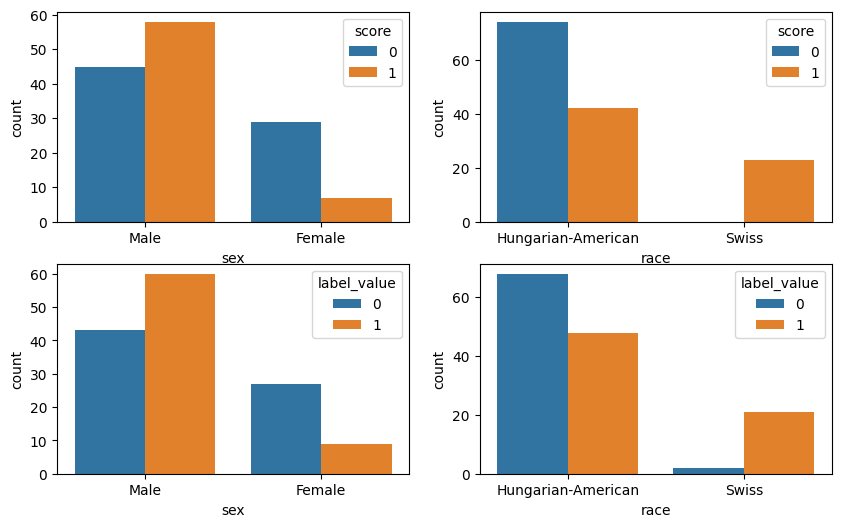

In [12]:
fig, ax = subplots(2, 2, figsize = (10, 6))

sns.countplot(x = "sex",  hue = "score", data = df_aeq1, ax = ax[0][0]);
sns.countplot(x = "race", hue = "score", data = df_aeq1, ax = ax[0][1]);

sns.countplot(x = "sex",  hue = "label_value", data = df_aeq1, ax = ax[1][0]);
sns.countplot(x = "race", hue = "label_value", data = df_aeq1, ax = ax[1][1]);

# 4. Visualize bias in the model ( Support Vector Classifier )

The DataFrame below presents evaluation metrics of a binary classifier that has been trained to predict a certain outcome based on two attributes: `sex` and `race`.

Here are some potential biases that could be interpreted from the DataFrame:

   * `Gender (Sex) bias`: The DataFrame shows that the model's true positive rate (tpr) for male subgroups is higher than for female subgroups. This suggests that the model may be less accurate in predicting positive outcomes for female subgroups. However, the false positive rate (fpr) for female subgroups is lower than for male subgroups, indicating that the model may be less likely to incorrectly classify females as having a positive outcome (having heart disease) when they actually had a negative outcome (being normal).
   
   * `Racial (Race) bias`: The DataFrame shows that the model's true positive rate (tpr) for Hungarian-American subgroups is lower than for Swiss subgroups. This suggests that the model may be less accurate in predicting positive outcomes for Hungarian-American subgroups. Additionally, the false positive rate (fpr) for Hungarian-American subgroups is higher than for Swiss subgroups, indicating that the model may be more likely to incorrectly classify Hungarian-Americans as having a positive outcome. These disparities may be due to inherent racial biases in the data.
   
Nonetheless, these disparities may be due to inherent gender and racial biases in the data, such as differences in healthcare utilization or disease prevalence between genders and races. The model may also be affected by gender and racial biases in its training data or algorithm, or both, which can lead to unequal performance across different gender subgroups.

In [13]:
# must discretize continuous attribute columns prior to passing the data to Group().get_crosstabs()
df_aeq, _ = preprocess_input_df(df_aeq1)

g = Group()
xtab, _ = g.get_crosstabs(df_aeq)

In [14]:
absolute_metrics = g.list_absolute_metrics(xtab)

xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,sex,Female,0.78,1.00,0.07,0.00,0.00,0.22,0.93,1.00,0.11,0.19,0.25
1,sex,Male,0.82,0.79,0.24,0.16,0.21,0.18,0.76,0.84,0.89,0.56,0.58
2,race,Hungarian-American,0.73,0.90,0.18,0.17,0.10,0.27,0.82,0.83,0.65,0.36,0.41
3,race,Swiss,1.00,0.00,NaN,0.09,1.00,0.00,NaN,0.91,0.35,1.00,0.91


# 5. What levels of disparity exist between population groups?

The DataFrame below shows various measures of disparity for our Support Vector Classifier based on two attributes: `sex` and `race`. The values presented are ratios that compare the performance of different subgroups with the overall population. A value of 1 indicates no disparity, while values above or below 1 indicate higher or lower levels of disparity, respectively.

Here are some observations:

For `sex`, there is significant disparity between female and male subgroups in terms of `ppr` (0.120690) and `pprev` (0.345307), indicating that males are more likely to be correctly classified as having a positive outcome (having heart disease) and have higher positive outcome rates than females. The `for` disparity for females is 0.282132, which indicates that females are less likely to be correctly classified as having a positive outcome (having heart disease) when they actually have a positive outcome compared to males. In other words, there is a significant disparity in the classifier's performance based on `sex` with respect to `for`. This means that the classifier is less accurate in predicting true positives for females compared to males.


For `race`, the `pprev` disparity is 2.761905, which indicates Swiss individuals have 2.761905 times higher probability of having a positive outcome (having heart disease) compared to Hungarian-Americans. Moreoverm there is significant disparity between Hungarian-American and Swiss subgroups in terms of `fdr` (0.521739), indicating that the model is more likely to incorrectly classify Swiss individuals as having a positive outcome (having heart disease) when they actually had a negative outcome (being normal). There is also high disparity in `fpr` (9.714286), meaning that Swiss individuals are more likely to be classified as having a positive outcome (having heart disease) when they actually had a negative outcome (being normal) compared to the reference group.

Also, we can see NaN values in `for` and `npv` disparities for Swiss individuals are NaN. In general, NaN values can occur when there is insufficient data or when certain calculations are not applicable to a particular subgroup. In this case, it may be that there were too few Swiss individuals in the dataset to calculate the false omission rate and negative predictive value (NPV) disparities. 

In [15]:
b = Bias()

# automate base group selection based on dataset characterisitcs
# the reference group is Male and Hungarian-American and can be manually written
# but it is decided that Aequitas handles it.
majority_bdf = b.get_disparity_major_group(xtab, original_df = df_aeq)

majority_bdf[['attribute_name', 'attribute_value'] +  b.list_disparities(majority_bdf)]

get_disparity_major_group()


,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,sex,Female,0.120690,0.345307,1.183673,0.000000,0.282132,0.000000,1.212121,0.952381,1.264706,1.232252
1,sex,Male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,race,Hungarian-American,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,race,Swiss,0.547619,2.761905,1.095652,0.521739,NaN,9.714286,0.000000,1.371429,0.000000,NaN


# 6. How to assess the model fairness?

Based on the information in the DataFrame below:

* The model does not achieve `Equalized Odds` and `Statistical Parity` for both `race` and `sex` attributes, meaning that there is evidence of disparity in the model's performance based on these attributes.

* The model achieves `NPV` Parity for both attributes, indicating that individuals with a negative outcome have the same probability of being correctly classified as having a negative outcome regardless of their `race` or `sex`.

* The model does not achieve `TNR` Parity for `race`, and all Swiss individuals are classified as having a positive outcome.

* The model does not achieve `FNR` Parity for sex attribute, indicating that individuals with a positive outcome have different probabilities of being correctly classified as having a positive outcome based on their `sex`.

* `Type I` (the proportion of true negative predictions for each group being equal), `Type II` parities (the proportion of true positive predictions for each group being equal), and `Supervised` (the classifier produces fair predictions for labeled data) and `Unsupervised` (the classifier produces fair predictions for unlabeled data) fairness are false for both `sex` and `race`, it means that the classifier is not producing fair predictions for either labeled or unlabeled data, and the proportion of true negatives and true positives is not equal for each group. This suggests that the classifier is systematically biased in its predictions and may be unfairly favoring or disfavoring certain subgroups.

In [16]:
f = Fairness()
fdf = f.get_group_value_fairness(majority_bdf)

In [17]:
gaf = f.get_group_attribute_fairness(fdf)
gaf[['attribute_name'] + f.list_parities(fdf)]

,attribute_name,Equalized Odds,Statistical Parity,NPV Parity,FNR Parity,FDR Parity,FPR Parity,TNR Parity,TPR Parity,TypeI Parity,TypeII Parity,FOR Parity,Impact Parity,Precision Parity,Supervised Fairness,Unsupervised Fairness
0,race,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False
1,sex,False,False,True,True,False,False,False,True,False,False,False,False,True,False,False


In [18]:
gof = f.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

# 7. What can be done after finding fairness violations?

After finding fairness violations in an algorithm, several actions can be taken to address the issue, including:

* `Adjusting the algorithm`: The algorithm can be modified to address the bias and improve fairness. This can involve adjusting the data used to train the model or the algorithm itself to remove the sources of bias.

* `Collecting more data`: Collecting more data from underrepresented groups can help to balance the dataset and reduce bias in the algorithm.

* `Removing or downweighting sensitive attributes`: Removing or downweighting sensitive attributes, such as race or gender, from the data can reduce the likelihood of bias in the algorithm.

* `Implementing fairness constraints`: Fairness constraints can be incorporated into the algorithm to ensure that it meets specific fairness criteria.

* `Monitoring and evaluating the algorithm`: It is important to continually monitor and evaluate the algorithm to ensure that it remains fair and unbiased over time. This can involve regularly checking for fairness violations and making adjustments as needed.